# Blind Image Deconvolution (BID) Demonstration

This notebook gives a demonstration of one type of Blind Image Deconvolution using the modified Davey Algorithm.

We begin with some housekeeping (Python imports)

In [1]:
import imageio                                                # Image file I/O
import numpy as np                                            # Matrix support, FFT etc
import math
from scipy import signal                                      # Signal processing library
from IPython.display import Math                              # LaTex support
import matplotlib.pyplot as plot                              # Plots

from modifiedDaveyDeblur import bid_davey, InitialEstimate    # Blind image deconvolution

Next, import our image of choice...

Source image dimensions: (452, 602, 3)


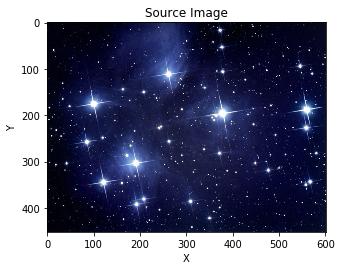

In [2]:
image_name = 'src_images/stars.bmp'


# Load and show source image
src_img = imageio.imread(image_name)
print "Source image dimensions:", src_img.shape

plot.figure(figsize=(5,5))
plot.title('Source Image')
plot.xlabel('X')
plot.ylabel('Y')
plot.imshow(src_img)

Next, we add some 'atmospheric blurring'. This is achieved by running the source image through a circular (pillbox) filter. The larger the blur kernel, the smoother the image becomes.

<img src="img/blurring.png" width="600">

If:
* f(x,y) is our source image before blurring
* h(x,y) is the effective transfer function modelling the blurring mechanism (Point Spread Function)
* g(x,y) is our blurred image


then the blurred image is the result of the 2D-convolution of each RGB colour channel with the PSF:

In [3]:
Math(r'g(x,y) =  f(x,y) \otimes h(x,y)')

<IPython.core.display.Math object>

Blurred image dimensions: (472, 622, 3)


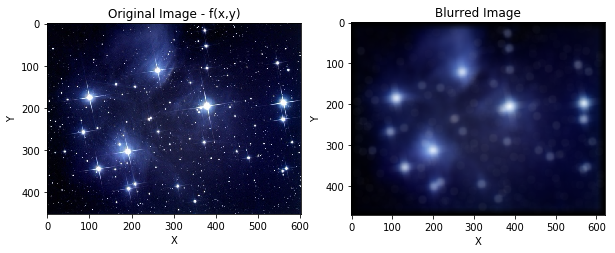

In [4]:
# Create circular filter PSF
r = 10
y,x = np.ogrid[-r: r+1, -r: r+1]
psf = x**2+y**2 <= r**2
psf = psf.astype(float) / np.sum(psf)


blur_img = np.zeros((src_img.shape[0] + 2*r, src_img.shape[1] + 2*r, src_img.shape[2]))
print "Blurred image dimensions:", blur_img.shape

for ch in range(src_img.shape[2]):    
    blur_img[:,:,ch] = signal.convolve2d(src_img[:,:,ch], psf, mode ='full', boundary = 'fill', fillvalue = 0)

    
# Plot before and after blurring    
plot.figure(figsize=(10,10))
plot.subplot(1, 2, 1)
plot.title('Original Image - f(x,y)')
plot.xlabel('X')
plot.ylabel('Y')
plot.imshow(src_img)

plot.subplot(1, 2, 2)
plot.title('Blurred Image')
plot.xlabel('X')
plot.ylabel('Y')
plot.imshow(blur_img/np.max(blur_img))


Realisitically some noise is added to the system during the capture process. This manifests from things like:
-  electronic noise
-  thermal noise at the CCD camera
-  quantisation noise

We model this by using an additive unknown noise term n(x,y), with the properites of being a zero-mean Gaussian random variable.

![image.png](img/1d_gaussian.jpg)

so we now have:

In [5]:
Math(r'g(x,y) =  f(x,y) \otimes h(x,y) + n(x,y)')

<IPython.core.display.Math object>

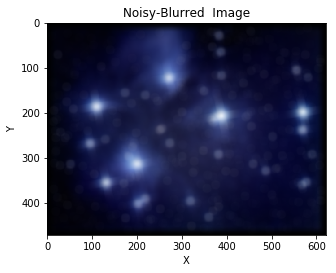

In [6]:
# Add Gaussian noise to the observed image
mu, sigma = 0, 0.1
scale = 0.0
noise = scale * np.multiply(np.random.normal(mu, sigma, blur_img.shape), blur_img)

noisyBlur_img = np.add(blur_img, noise)
noisyBlur_img = np.round(noisyBlur_img, 0).astype(np.uint8)
imageio.imsave( '_blurred.'.join(image_name.rsplit('.', 1)), (np.divide(noisyBlur_img, np.max(noisyBlur_img))*255).astype(np.uint8))

# Plot noisy, blurred image
plot.figure(figsize=(5,5))
plot.title('Noisy-Blurred  Image')
plot.xlabel('X')
plot.ylabel('Y')
plot.imshow(noisyBlur_img)

We can define the signal to noise ratio (SNR) as:

In [7]:
Math(r'SNR = 20\log_{10}  \Bigg(   \frac {A_{signal}} {A_{noise}} \Bigg)')

<IPython.core.display.Math object>

In [8]:
Math(r'SNR (dB) = P(dB)_{signal} - P (dB)_{noise}')

<IPython.core.display.Math object>

In [9]:
def power(image):
    return 20*np.log10( np.sqrt(np.mean(np.square(image))) )

signalPower = power(blur_img)
noisePower  = power(noise)
snr         = signalPower - noisePower
print("SNR = {0} dB".format(snr))


SNR = inf dB


/home/hayden/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0,0.5,u'Y')

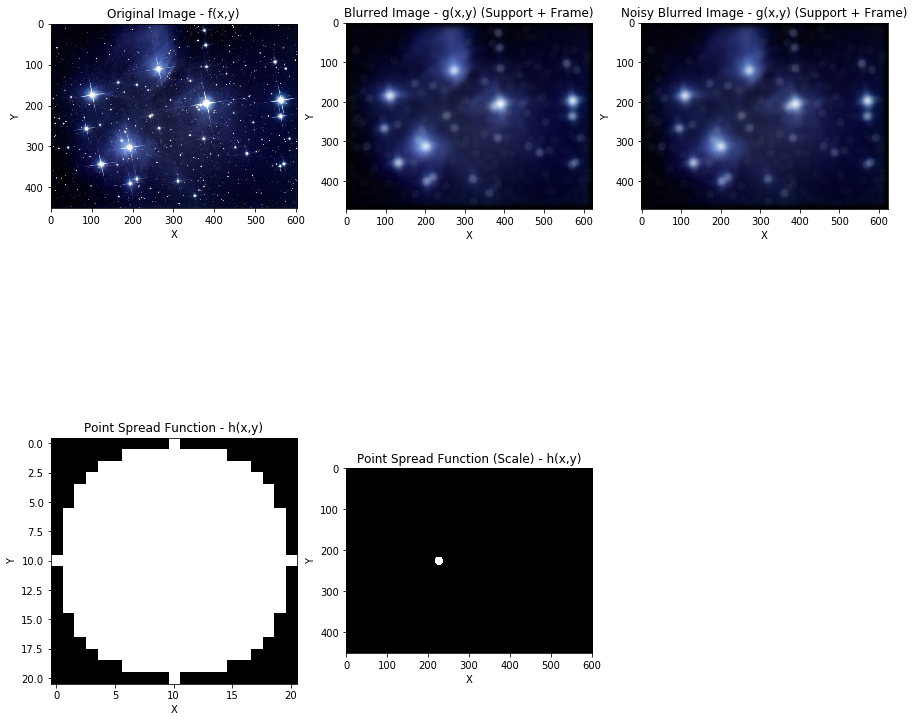

In [10]:
 
# Plot before and after blurring    
plot.figure(figsize=(15,15))
plot.subplot(2, 3, 1)
plot.imshow(src_img)
plot.title('Original Image - f(x,y)')
plot.xlabel('X')
plot.ylabel('Y')

plot.subplot(2, 3, 2)
plot.imshow(blur_img/np.max(blur_img))
plot.title('Blurred Image - g(x,y) (Support + Frame)')
plot.xlabel('X')
plot.ylabel('Y')

plot.subplot(2, 3, 3)
plot.imshow(noisyBlur_img)
plot.title('Noisy Blurred Image - g(x,y) (Support + Frame)')
plot.xlabel('X')
plot.ylabel('Y')


# Show PSF
psfplot = np.zeros((src_img.shape[0], src_img.shape[1]))
nb = psfplot.shape[0]
na = psf.shape[0]
lower = (nb) // 2 - (na // 2)
upper = (nb) // 2 + math.ceil(float(na) / 2)
psfplot[lower:int(upper), lower:int(upper)] = psf

plot.subplot(2, 3, 4)
plot.imshow(psf, cmap='gray')
plot.title('Point Spread Function - h(x,y)')
plot.xlabel('X')
plot.ylabel('Y')

plot.subplot(2, 3, 5)
plot.imshow(psfplot, cmap='gray')
plot.title('Point Spread Function (Scale) - h(x,y)')
plot.xlabel('X')
plot.ylabel('Y')

Next we apply the Davey Blind image deconvolution algorithm to iteratively 'deblur' the noisy image...

<img src="img/davey_algorithm_flow.png" width="600">



Performing optimal deblur. Progress: [ . . . . . . . . . . . . . . . . . . . . ] (complete)
Results:
--------
Minimum MSE of 286 occurs at iteration# 1763.


Text(0,0.5,u'MSE')

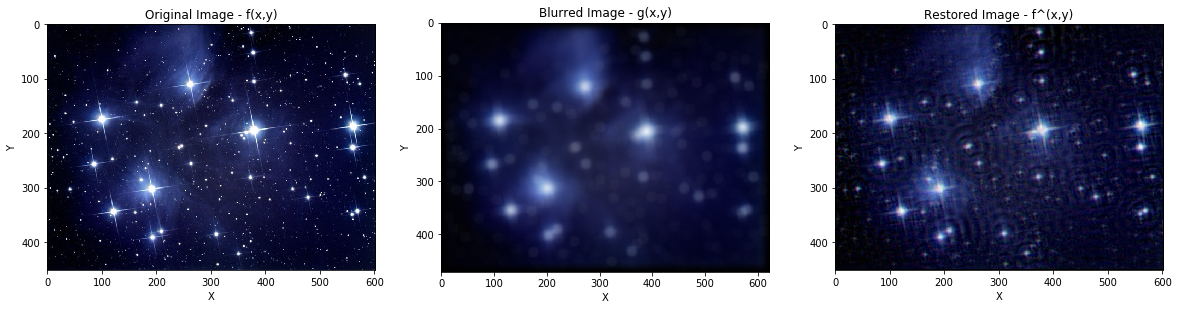

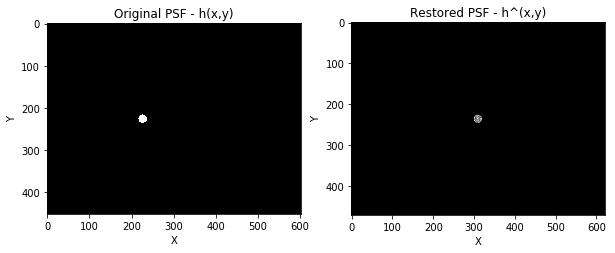

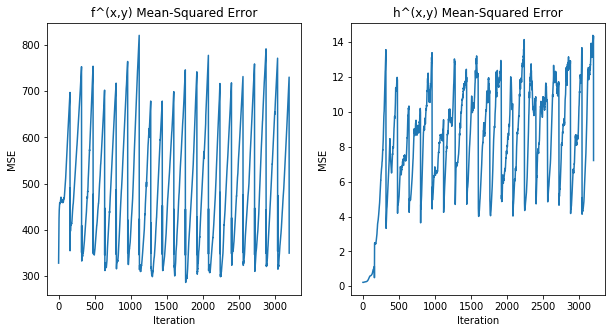

In [11]:
# BID iterations
iterations = 3200
save_snapshots = True

(restored_img, restored_psf, image_mse, psf_mse, mse_min, mse_min_iterations) = bid_davey(src_img, psfplot, noisyBlur_img, psf.shape, iterations, InitialEstimate.BLURRED_IMAGE, save_snapshots)

imageio.imsave( '_restored.'.join(image_name.rsplit('.', 1))  , restored_img) # Save the result



print "Results:"
print "--------"
print "Minimum MSE of %d occurs at iteration# %d." % (math.ceil(mse_min), mse_min_iterations)

# Plot recovered image
plot.figure(figsize=(20,20))
plot.subplot(1, 3, 1)
plot.imshow(src_img)
plot.title('Original Image - f(x,y)')
plot.xlabel('X')
plot.ylabel('Y')

plot.subplot(1, 3, 2)
plot.imshow(noisyBlur_img)
plot.title('Blurred Image - g(x,y)')
plot.xlabel('X')
plot.ylabel('Y')

plot.subplot(1, 3, 3)
plot.imshow(restored_img)
plot.title('Restored Image - f^(x,y)')
plot.xlabel('X')
plot.ylabel('Y')


# Plot recovered PSF
plot.figure(figsize=(10,10))
plot.subplot(1, 2, 1)
plot.imshow(psfplot, cmap='gray')
plot.title('Original PSF - h(x,y)')
plot.xlabel('X')
plot.ylabel('Y')

plot.subplot(1, 2, 2)
plot.imshow(restored_psf, cmap='gray')
plot.title('Restored PSF - h^(x,y)')
plot.xlabel('X')
plot.ylabel('Y')


# Plot MSE
plot.figure(figsize=(10,5))
plot.subplot(1, 2, 1)
plot.plot(image_mse[:,1])
plot.title('f^(x,y) Mean-Squared Error')
plot.xlabel('Iteration')
plot.ylabel('MSE')

plot.subplot(1, 2, 2)
plot.plot(psf_mse[:,1])
plot.title('h^(x,y) Mean-Squared Error')
plot.xlabel('Iteration')
plot.ylabel('MSE')

